In [2]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [8]:
sales_data = pd.read_csv("C:\\Users\\BHANARAM\\Downloads\\Tractor-Sales.csv")
sales_data.head()

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [12]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))
dates

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [11]:
import calendar
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year
sales_data.head()

,Month-Year,Number of Tractor Sold,Month,Year
0,Jan-03,141,Jan,2003
1,Feb-03,157,Feb,2003
2,Mar-03,185,Mar,2003
3,Apr-03,199,Apr,2003
4,May-03,203,May,2003


In [13]:
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]

In [14]:
sales_data

,Month,Year,Tractor-Sales
0,Jan,2003,141
1,Feb,2003,157
2,Mar,2003,185
3,Apr,2003,199
4,May,2003,203
...,...,...,...
139,Aug,2014,848
140,Sep,2014,640
141,Oct,2014,581
142,Nov,2014,519


In [15]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [16]:
# check out first 5 samples of the data
sales_data.head(5)

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [17]:
# extract out the time-series
sales_ts = sales_data['Tractor-Sales']

Text(0, 0.5, 'Tractor Sales')

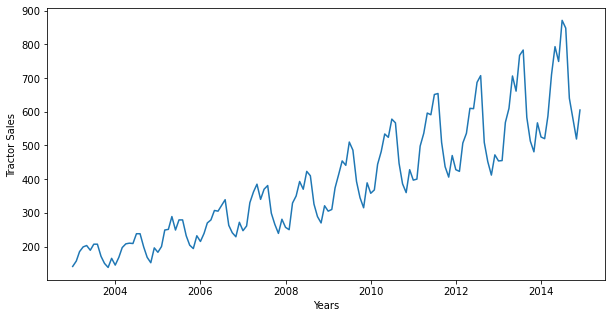

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

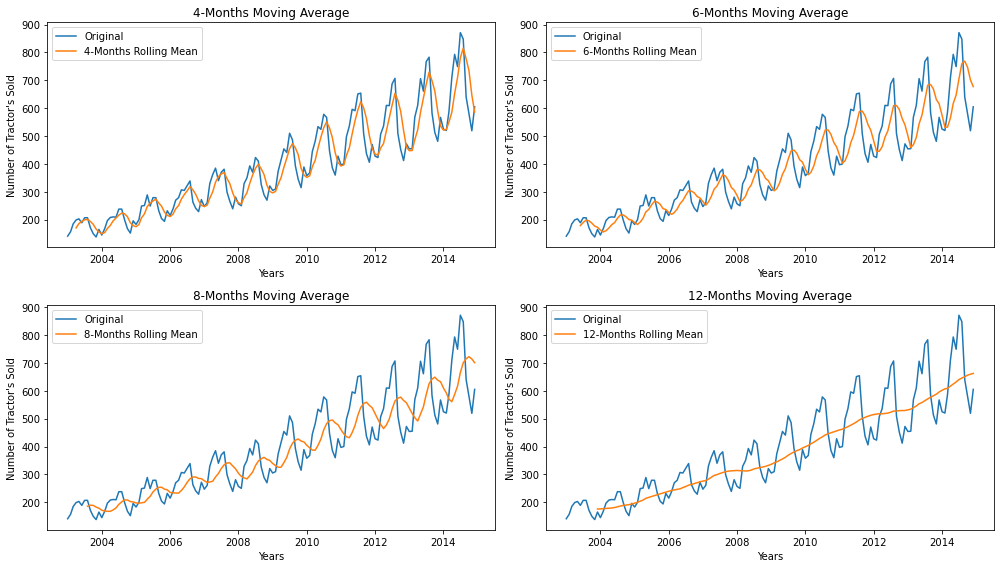

In [19]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

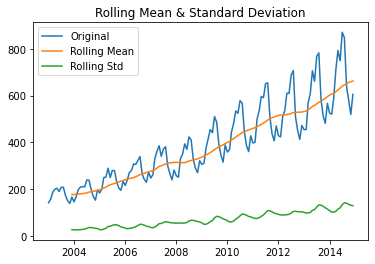

In [20]:
#Determing rolling statistics
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [21]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [23]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts.rolling(window=12).mean()[11:], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.907362
p-value                          0.993186
#lags Used                       2.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [24]:
monthly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Year", index = "Month")

In [25]:
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Apr,199,208,251,279,362,350,414,482,536,536,610,710
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Dec,165,196,232,272,281,321,389,428,470,472,567,605
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Mar,185,197,249,270,330,329,374,444,498,507,568,587
May,203,210,289,307,385,393,454,534,596,610,706,793


In [26]:
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


<AxesSubplot:xlabel='Month'>

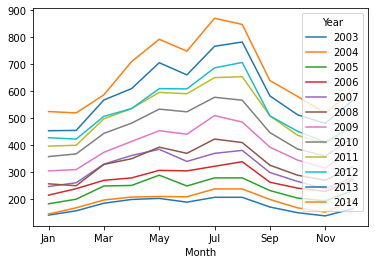

In [27]:
monthly_sales_data.plot()

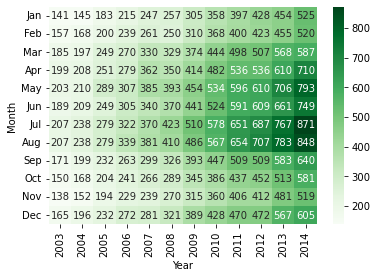

In [28]:
# Another way of looking at above graph through Heatmap
sns.heatmap(monthly_sales_data, annot=True, cmap='Greens', fmt='g');

In [29]:
# Transposed view of monthly_sales_data
monthly_sales_data.T

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


<AxesSubplot:>

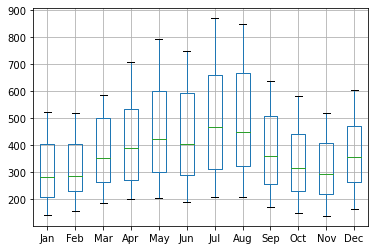

In [30]:
monthly_sales_data.T.boxplot()

In [31]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative')

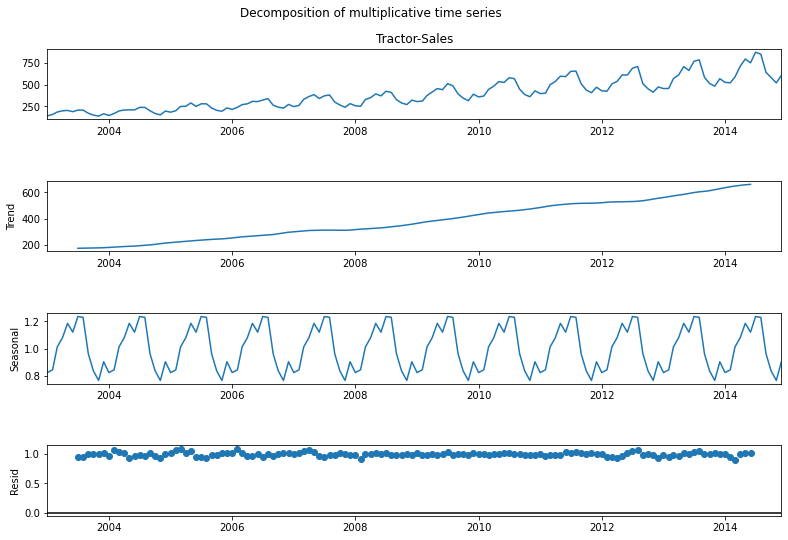

In [32]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

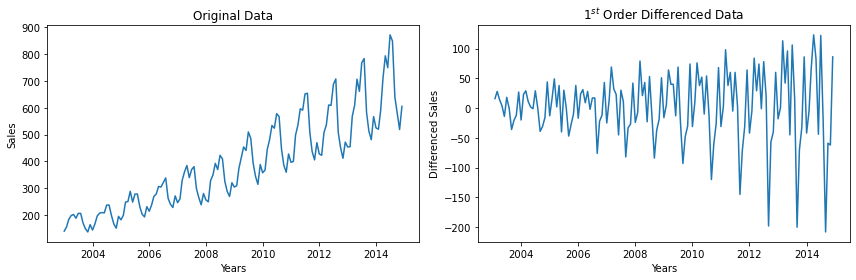

In [36]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
axes[0].plot(sales_data.index, sales_data['Tractor-Sales'])
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Sales")
axes[0].set_title("Original Data")
axes[1].plot(sales_data.index, sales_data['Tractor-Sales'].diff(periods=1))
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Differenced Sales")
axes[1].set_title("1$^{st}$ Order Differenced Data")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Tractor Sales')

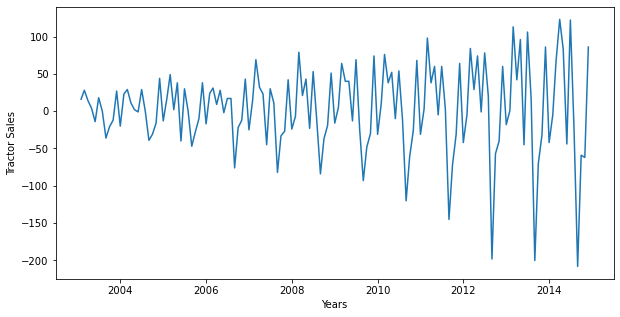

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

Text(0, 0.5, 'Log (Tractor Sales)')

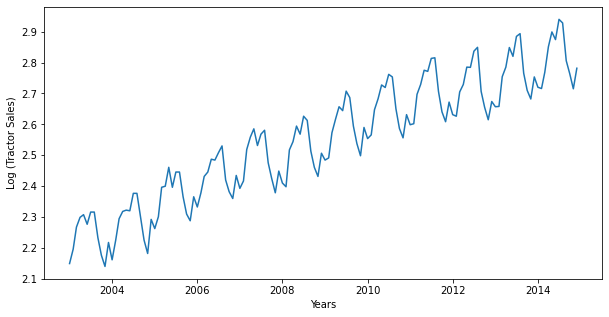

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log (Tractor Sales)')

Text(0, 0.5, 'Differenced Log (Tractor Sales)')

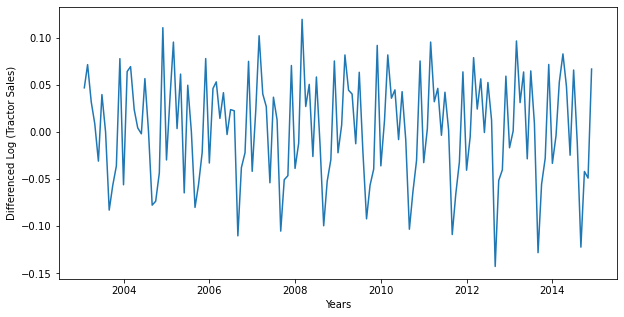

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')

In [41]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [44]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [45]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [42]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAXNonexNone12 model - AIC:inf


In [43]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 0)x(0, 1, 0, 12)12 model - AIC:1123.1799079151556


In [48]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [51]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [53]:
pred_dynamic_ci

,lower Tractor-Sales,upper Tractor-Sales
2012-01-01,407.576270,475.032053
2012-02-01,401.075996,468.531779
2012-03-01,486.001550,553.457333
2012-04-01,513.475814,580.931597
2012-05-01,562.861460,630.317242
2012-06-01,567.587747,635.043530
2012-07-01,631.185413,698.641196
2012-08-01,649.475885,716.931668
2012-09-01,528.063610,595.519392
2012-10-01,419.894809,487.350592


In [54]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [55]:
pred_dynamic_ci

,lower Tractor-Sales,upper Tractor-Sales
2012-01-01,407.576270,475.032053
2012-02-01,402.692655,486.597196
2012-03-01,489.491778,587.111763
2012-04-01,520.375554,630.008355
2012-05-01,572.638200,693.091677
2012-06-01,562.481831,692.861008
2012-07-01,615.784528,755.385456
2012-08-01,613.412941,761.663097
2012-09-01,470.312837,626.734696
2012-10-01,397.310963,561.498318


In [56]:
sales_data.tail()

,Month,Year,Tractor-Sales
2014-08-01,Aug,2014,848
2014-09-01,Sep,2014,640
2014-10-01,Oct,2014,581
2014-11-01,Nov,2014,519
2014-12-01,Dec,2014,605


In [57]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [58]:
pred_ci_99

,lower Tractor-Sales,upper Tractor-Sales
2015-01-01,532.891763,600.347546
2015-02-01,520.178898,604.083439
2015-03-01,581.215558,678.835543
2015-04-01,689.307288,798.940088
2015-05-01,765.208148,885.661626
2015-06-01,717.658284,848.037461
2015-07-01,830.311251,969.912179
2015-08-01,806.197941,954.448097
2015-09-01,600.747657,757.169516
2015-10-01,538.932996,703.120351


In [ ]:
a